In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

### Strategy

In [2]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [3]:
print(f"Numbers of GPU: {strategy.num_replicas_in_sync}")

Numbers of GPU: 2


### Reading the data

In [4]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearnin/DATASETS/CatsVsDogs/cats_vs_dogs_small/')

In [5]:
tr_d = image_dataset_from_directory(
    w_dir / 'train',
    image_size=(180,180)
)

va_d = image_dataset_from_directory(
    w_dir / 'validation',
    image_size=(180,180)
)

te_d = image_dataset_from_directory(
    w_dir / 'test',
    image_size=(180,180)
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

tr_d = tr_d.prefetch(buffer_size=AUTOTUNE)
va_d = va_d.prefetch(buffer_size=AUTOTUNE)
te_d = te_d.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

### The model

In [9]:
with strategy.scope():
    inputs = keras.Input(shape=(180,180,3))
    
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    
    x = layers.Conv2D(32, 5, use_bias=False)(x)
    
    for size in [32,64,128,256,512]:
        residual = x
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(size, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(size, 3, padding='same', use_bias=False)(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding='same', use_bias=False)(residual)
        
        x = layers.add([x, residual])
        
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )                  

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='distri_batch_residual.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    
    # To monitor the training in TensorBoard
    keras.callbacks.TensorBoard(
        log_dir='/home/antirrabia/Documents/DeepLearnin/Notebooks/TensorBoard_Logs/'
    )
]

history = model.fit(
    tr_d,
    epochs=70,
    validation_data=va_d,
    callbacks=callbacks
)

Epoch 1/70
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
63/63 [==============================] - 30s 202ms/step - loss: 6.4731 - accuracy: 0.5075 - val_loss: 0.6956 - val_accuracy: 0.4840
Epoch 2/70
63/63 [==============================] - 9s 136ms/step - loss: 1.5009 - accuracy: 0.5225 - val_loss: 0.7294 - val_accuracy: 0.5000
Epoch 3/70
63/63 [==============================] - 9s 137ms/step - loss: 1.0691 - accuracy: 0.5320 - val_loss: 0.8613 - val_accuracy: 0.5000
Epoch 4/70
63/63 [==============================] - 9s 138ms/step - loss: 0.9249 - accuracy: 0.5290 - val_loss: 0.7316 - val_accuracy: 0.5010
Epoch 5/70
63/63 [==============================] - 9s 142ms/step - loss: 0.8079 - accuracy: 0.5420 - val_loss: 0.6912 - val_accuracy: 0.5160
Epoch 6/70
63/63 [==============================] - 9s 140ms/step - loss: 0.8035 - accuracy: 0.5355 - val_loss: 0.784

### Plotting the training

Text(0.5, 1.0, 'Training and Validation Loss')

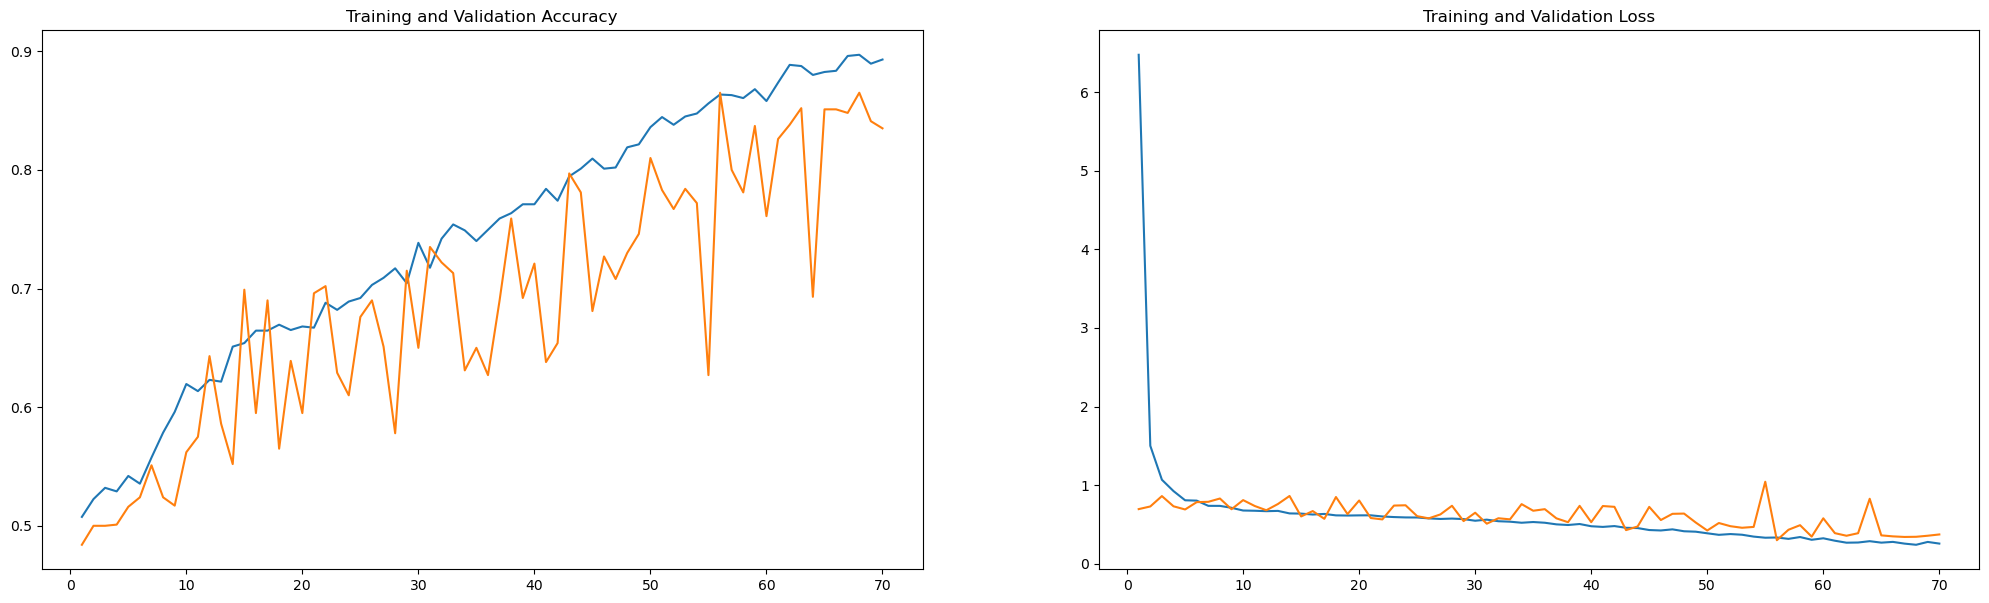

In [11]:
accuracy = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy)+1)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(25,7))

ax[0].plot(epochs, accuracy, label='Training Accuracy')
ax[0].plot(epochs, val_accu, label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(epochs, loss, label='Training Loss')
ax[1].plot(epochs, val_loss, label='Validation Loss')
ax[1].set_title('Training and Validation Loss')

### Testing the model

In [12]:
te_model = keras.models.load_model('distri_batch_residual.keras')

te_loss, te_accuracy = te_model.evaluate(te_d)

print(f"Test accuracy: {te_accuracy:.3f}")

63/63 [==============================] - 5s 48ms/step - loss: 0.3306 - accuracy: 0.8605
Test accuracy: 0.860
